## This is for preprocessing the event data from the labelled dataset

In [125]:
import pandas as pd
import matplotlib.pyplot as plt


In [126]:
event_data = pd.read_csv("/Users/annadaugaard/Desktop/VFF/raw_data/sample_match_1/Sample_Game_1_RawEventsData.csv")
event_data_passes = event_data[event_data["Type"] == "PASS"]
event_data_passes["From"] = (event_data_passes["From"].astype(str).str.replace("Player", "", regex=True)).astype(int)
event_data_passes["To"] = (event_data_passes["To"].astype(str).str.replace("Player", "", regex=True)).astype(int)
event_data_passes["Start X"] = (event_data_passes["Start X"]).astype(float) * 106
event_data_passes["End X"] = (event_data_passes["End X"]).astype(float) * 106
event_data_passes["Start Y"] = (event_data_passes["Start Y"]).astype(float) * 68
event_data_passes["End Y"] = (event_data_passes["End Y"]).astype(float) * 68

/var/folders/hg/l2wdlfb97db6m9qjl00xzxg40000gn/T/ipykernel_48684/941749229.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_passes["From"] = (event_data_passes["From"].astype(str).str.replace("Player", "", regex=True)).astype(int)
/var/folders/hg/l2wdlfb97db6m9qjl00xzxg40000gn/T/ipykernel_48684/941749229.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data_passes["To"] = (event_data_passes["To"].astype(str).str.replace("Player", "", regex=True)).astype(int)
/var/folders/hg/l2wdlfb97d

In [127]:
players = pd.read_csv("/Users/annadaugaard/Desktop/VFF/explore/labelled_match_players.csv", index_col=0)
players

,period,frame,time,id,x,y,z,Team
0,1.0,1.0,0.04,16,71.72,31.76,0,away
1,1.0,1.0,0.04,8,48.11,14.40,0,home
2,1.0,1.0,0.04,7,41.47,22.13,0,home
3,1.0,1.0,0.04,6,44.20,32.53,0,home
4,1.0,1.0,0.04,5,43.56,49.36,0,home
...,...,...,...,...,...,...,...,...
3190133,2.0,145006.0,5800.24,16,27.20,40.85,0,away
3190134,2.0,145006.0,5800.24,15,18.75,38.54,0,away
3190135,2.0,145006.0,5800.24,28,23.11,55.13,0,away
3190136,2.0,145006.0,5800.24,7,39.64,42.46,0,home


In [128]:
ball = pd.read_csv("/Users/annadaugaard/Desktop/VFF/explore/labelled_match_ball.csv", index_col=0)
ball

,time,ball_x,ball_y
0,0.04,48.20,26.32
1,0.08,52.62,27.65
2,0.12,56.94,28.94
3,0.16,58.67,28.72
4,0.20,58.84,27.59
...,...,...,...
145001,5800.08,NaN,NaN
145002,5800.12,NaN,NaN
145003,5800.16,NaN,NaN
145004,5800.20,NaN,NaN


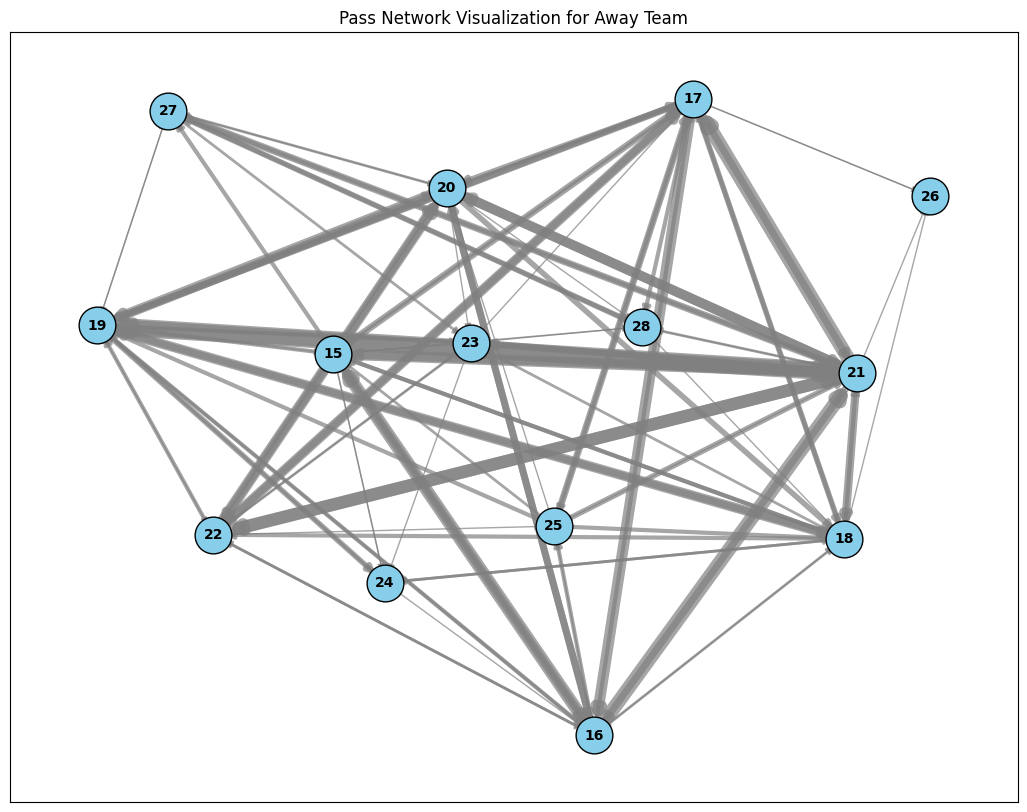

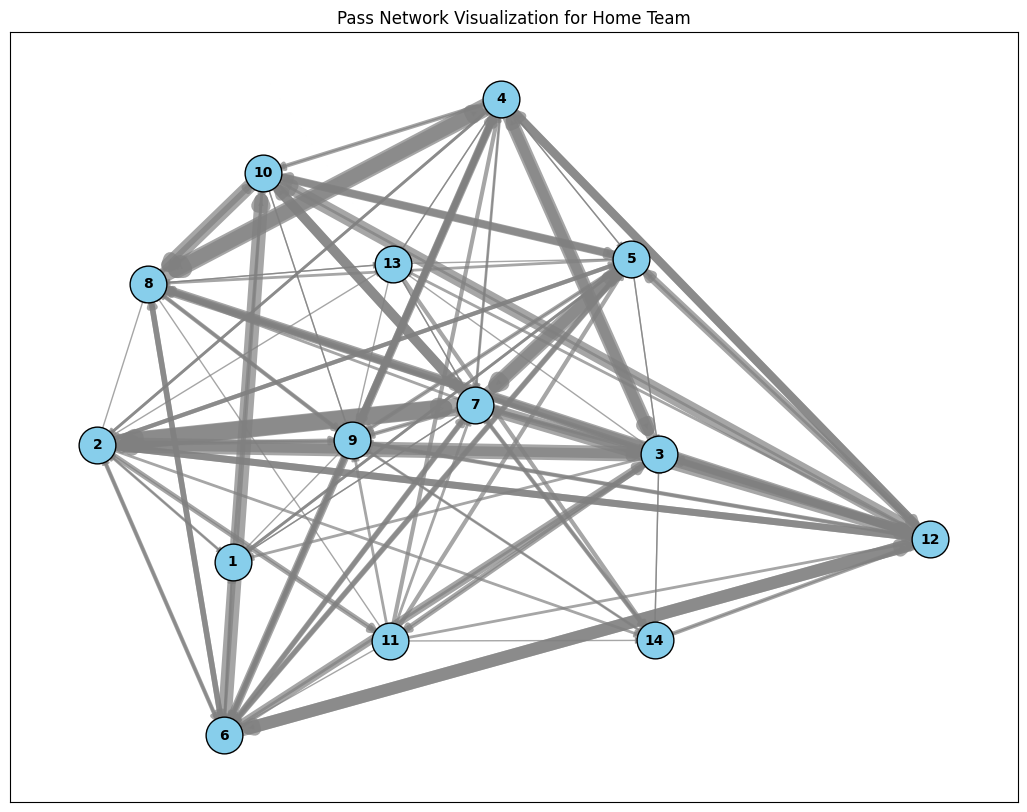

In [129]:
import networkx as nx

# Function to create a pass network plot
def plot_pass_network(df_passes):
    """
    Creates a pass network plot where nodes represent players and edges represent passes.
    The thickness of edges is proportional to the number of passes between players.

    Parameters:
        df_passes (pd.DataFrame): The DataFrame containing pass data.
    """
    teams = df_passes["Team"].unique()

    for team in teams:
        team_passes = df_passes[df_passes["Team"] == team]
        # Create a directed graph
        G = nx.DiGraph()

        # Count passes between players
        pass_counts = team_passes.groupby(["From", "To"]).size().reset_index(name="pass_count")

        # Add nodes (players)
        players = set(pass_counts["From"]).union(set(pass_counts["To"]))
        G.add_nodes_from(players)

        # Add weighted edges based on pass counts
        for _, row in pass_counts.iterrows():
            G.add_edge(row["From"], row["To"], weight=row["pass_count"])

        # Draw the network graph
        plt.figure(figsize=(13, 10))
        pos = nx.kamada_kawai_layout(G)  # Positioning nodes
        edge_weights = [G[u][v]["weight"] for u, v in G.edges()]

        # Draw nodes and edges
        nx.draw_networkx_nodes(G, pos, node_size=700, node_color="skyblue", edgecolors="black")
        nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.7, edge_color="gray")
        nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

        plt.title(f"Pass Network Visualization for {team} Team")
        plt.show()

# Generate the pass network plot
plot_pass_network(event_data_passes)


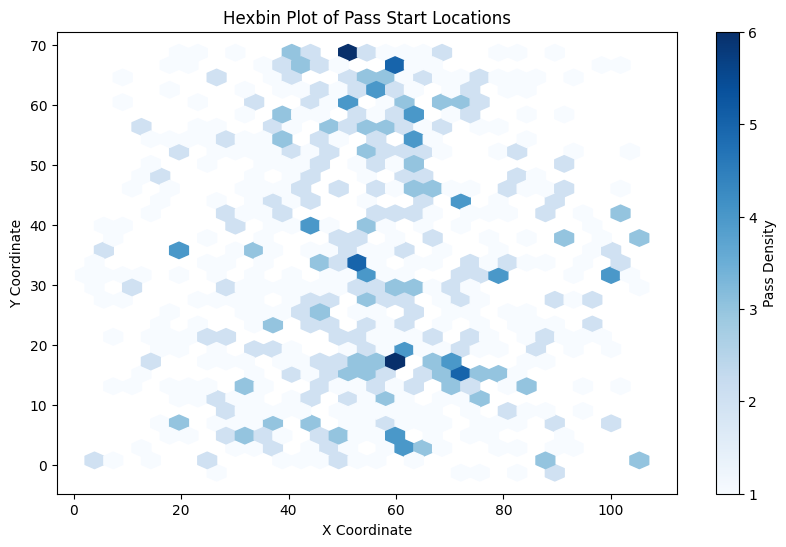

In [130]:
# Function to create a hexbin plot for pass start locations with corrected column names
def plot_hexbin_passes(df_passes):
    """
    Creates a hexbin plot to visualize the density of pass start locations.

    Parameters:
        df_passes (pd.DataFrame): The DataFrame containing pass data.
    """
    plt.figure(figsize=(10, 6))
    hb = plt.hexbin(df_passes["Start X"], df_passes["Start Y"], gridsize=30, cmap="Blues", mincnt=1)

    plt.colorbar(hb, label="Pass Density")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("Hexbin Plot of Pass Start Locations")
    plt.show()

# Generate the hexbin plot for pass start locations
plot_hexbin_passes(event_data_passes)


In [131]:
# Function to plot individual passes with a convex hull for each pass separately
def plot_each_pass_with_convex_hull(df_passes, df_players, from_player, to_player):
    """
    Creates individual plots for each pass from a given "From" player to a "To" player.
    Each plot shows the pass along with a closed convex hull around the outfield player positions.

    Parameters:
        df_passes (pd.DataFrame): The DataFrame containing pass data.
        df_players (pd.DataFrame): The DataFrame containing player positions with time.
        from_player (int): The ID of the player making the pass.
        to_player (int): The ID of the player receiving the pass.
    """
    pitch = Pitch(line_color='black')

    # Filter passes for the specific player pair
    pair_passes = df_passes[(df_passes["From"] == from_player) & (df_passes["To"] == to_player)]

    if pair_passes.empty:
        print(f"No passes found from player {from_player} to player {to_player}.")
        return

    # Assign colors dynamically based on teams
    unique_teams = df_players["Team"].unique()
    team_colors = {team: color for team, color in zip(unique_teams, ["cornflowerblue", "tomato"])}

    for _, row in pair_passes.iterrows():
        fig, ax = pitch.draw(figsize=(8, 6))  # Create a new plot for each pass

        # Get player positions at the start of the pass
        player_positions = df_players[df_players["time"] == row["Start Time [s]"]]

        if not player_positions.empty:
            # Assign colors based on the players' team
            player_positions["color"] = player_positions["Team"].map(team_colors)

            # Identify goalkeepers (leftmost and rightmost players)
            min_x = player_positions["x"].min()
            max_x = player_positions["x"].max()
            outfield_players = player_positions[(player_positions["x"] != min_x) & (player_positions["x"] != max_x)]
            goalkeepers = player_positions[(player_positions["x"] == min_x) | (player_positions["x"] == max_x)]

            # Draw convex hull only for outfield players
            if len(outfield_players) > 2:  # Convex Hull needs at least 3 points
                hull = pitch.convexhull(outfield_players["x"], outfield_players["y"])
                pitch.polygon(hull, ax=ax, edgecolor=outfield_players["color"].iloc[0], 
                              facecolor=outfield_players["color"].iloc[0], alpha=0.3)

            # Scatter plot for players
            pitch.scatter(player_positions["x"], player_positions["y"], ax=ax, edgecolor="black", 
                          facecolor=player_positions["color"], alpha=0.8)

            # Mark goalkeepers distinctly
            pitch.scatter(goalkeepers["x"], goalkeepers["y"], ax=ax, edgecolor="black", 
                          facecolor="red", alpha=1, label="Goalkeepers", zorder=3)

        # Plot passes (colored based on the team of the passing player)
        passer_team = df_players[df_players["id"] == row["From"]]["Team"].iloc[0] if row["From"] in df_players["id"].values else None
        pass_color = team_colors.get(passer_team, "gray")

        pitch.arrows(row["Start X"], row["Start Y"], row["End X"], row["End Y"], 
                     width=2, headwidth=6, headlength=6, color=pass_color, ax=ax, alpha=0.7)

        plt.title(f"Pass from {from_player} to {to_player}")
        plt.show()  # Display each pass separately



/var/folders/hg/l2wdlfb97db6m9qjl00xzxg40000gn/T/ipykernel_48684/2661086842.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_positions["color"] = player_positions["Team"].map(team_colors)


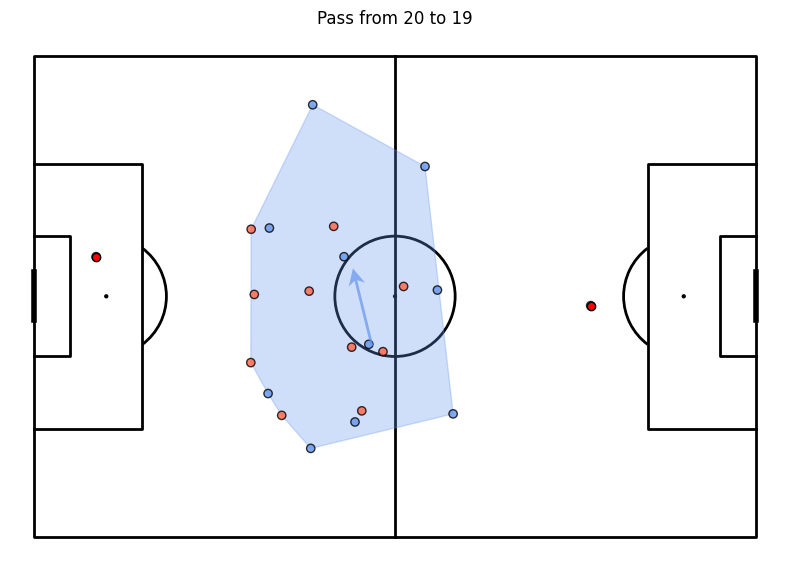

/var/folders/hg/l2wdlfb97db6m9qjl00xzxg40000gn/T/ipykernel_48684/2661086842.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_positions["color"] = player_positions["Team"].map(team_colors)


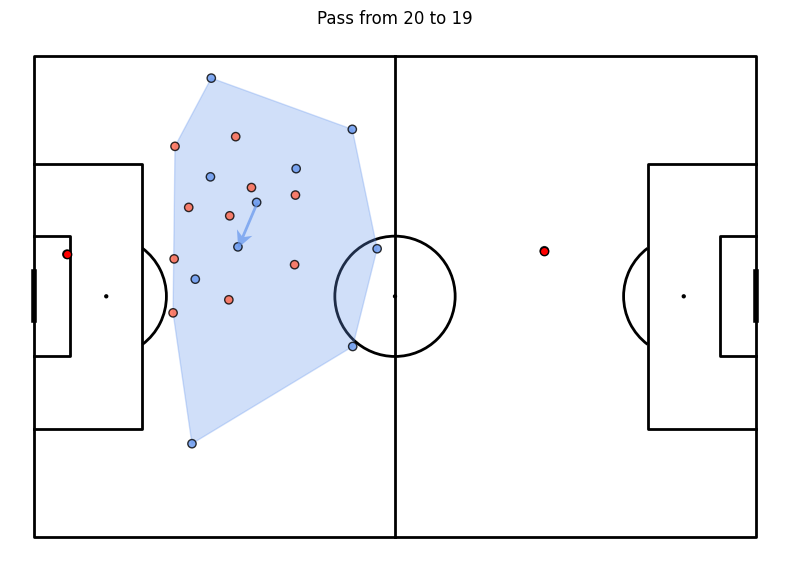

/var/folders/hg/l2wdlfb97db6m9qjl00xzxg40000gn/T/ipykernel_48684/2661086842.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_positions["color"] = player_positions["Team"].map(team_colors)


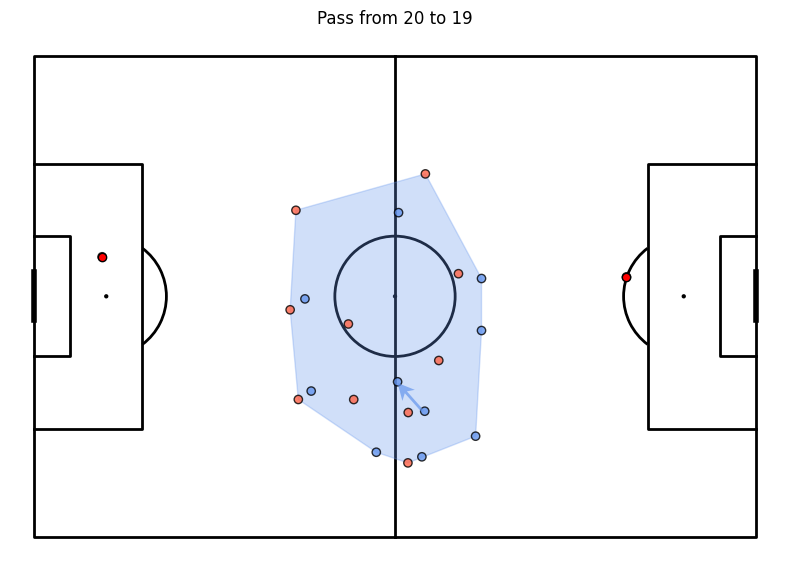

/var/folders/hg/l2wdlfb97db6m9qjl00xzxg40000gn/T/ipykernel_48684/2661086842.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_positions["color"] = player_positions["Team"].map(team_colors)


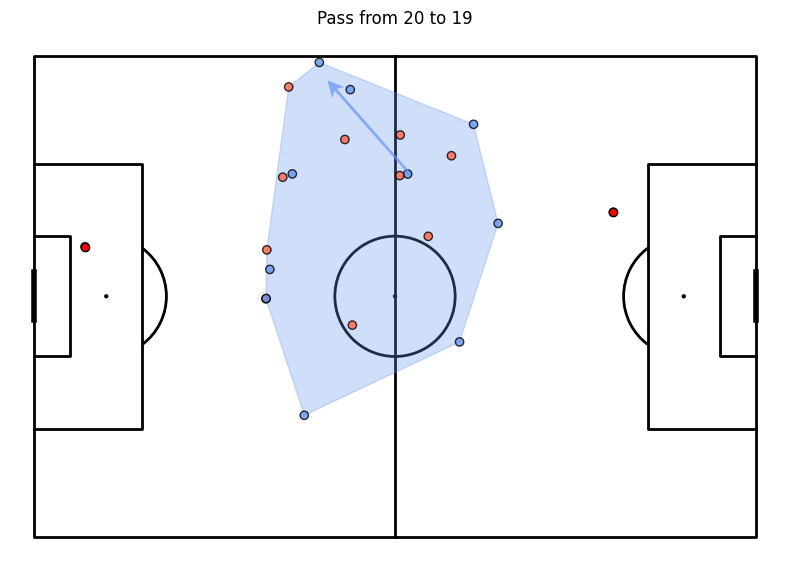

/var/folders/hg/l2wdlfb97db6m9qjl00xzxg40000gn/T/ipykernel_48684/2661086842.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_positions["color"] = player_positions["Team"].map(team_colors)


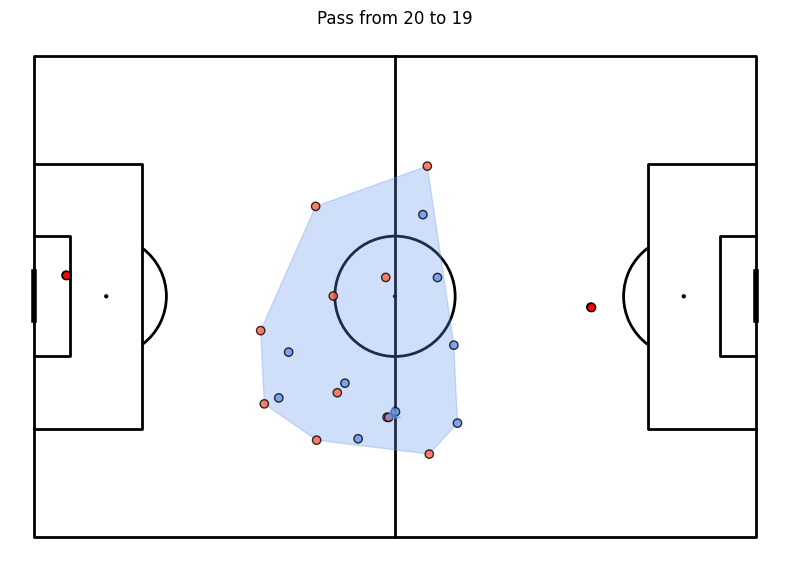

/var/folders/hg/l2wdlfb97db6m9qjl00xzxg40000gn/T/ipykernel_48684/2661086842.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_positions["color"] = player_positions["Team"].map(team_colors)


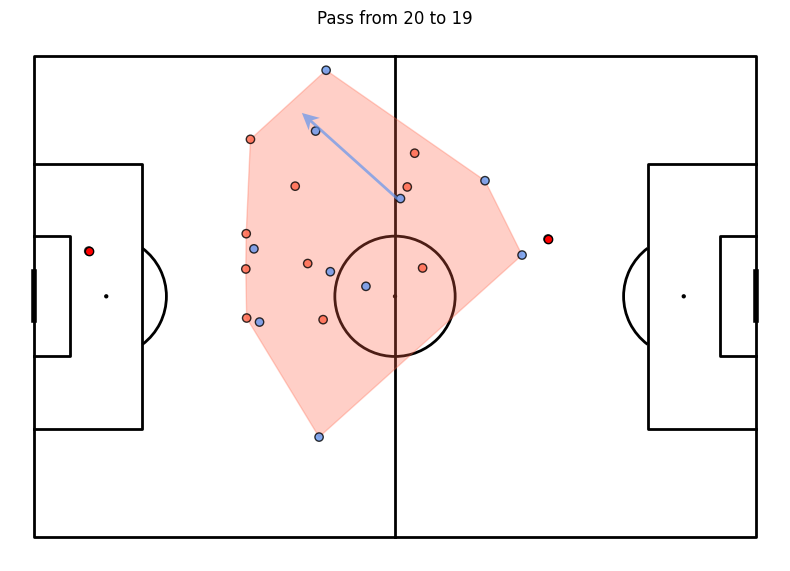

/var/folders/hg/l2wdlfb97db6m9qjl00xzxg40000gn/T/ipykernel_48684/2661086842.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_positions["color"] = player_positions["Team"].map(team_colors)


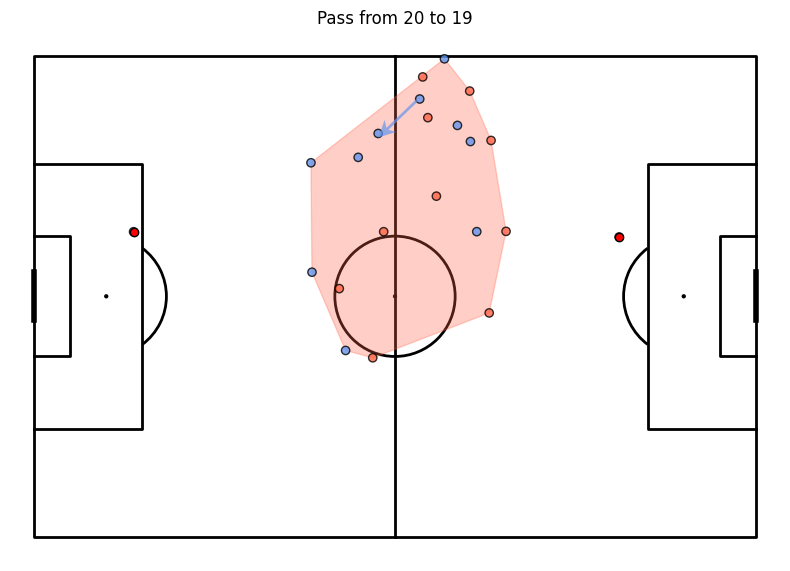

In [132]:
plot_each_pass_with_convex_hull(event_data_passes, players, from_player=20, to_player=19)

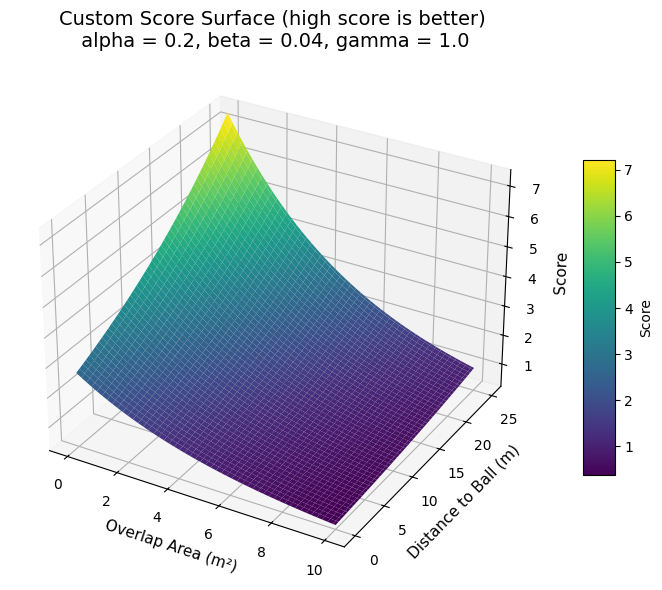

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters (feel free to tweak) ---
alpha = 0.2     # Weight on overlap area
beta = 0.04     # Weight on distance to ball
gamma = 1.0     # Directional bonus

# --- Create value ranges ---
overlap_values = np.linspace(0, 10, 100)         # From 0 to 5 m² overlap
distance_values = np.linspace(0, 25, 100)       # From 0 to 10 meters
Overlap, Distance = np.meshgrid(overlap_values, distance_values)

# Assume the ball is moving forward (so direction bonus is +gamma)
direction_bonus = gamma

# --- Score formula ---
Penalty = alpha * Overlap + beta * (-Distance)
Score = np.exp(-Penalty + direction_bonus)

# --- Plotting ---
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Overlap, Distance, Score, cmap='viridis', edgecolor='none')

ax.set_xlabel('Overlap Area (m²)', fontsize=11)
ax.set_ylabel('Distance to Ball (m)', fontsize=11)
ax.set_zlabel('Score', fontsize=11)
ax.set_title('Custom Score Surface (high score is better)\n alpha = 0.2, beta = 0.04, gamma = 1.0', fontsize=14)

fig.colorbar(surf, shrink=0.6, aspect=10, label='Score')
plt.tight_layout()
plt.show()

